In [8]:
# Install and load necessary packages
install.packages(c("tidyverse", "zoo", "quantmod", "keras", "caret", "reshape2"))
library(tidyverse)
library(zoo)
library(quantmod)
library(keras)
library(caret)
library(reshape2)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [9]:
# 2. Read CSV file and set index to Close
data <- read.csv('./sample_data/ETH-USD.csv')

# Function to convert string to number
convert_str_to_number <- function(value) {
  if (is.character(value)) {
    return(as.numeric(gsub(',', '', value)))
  } else {
    return(as.numeric(value))
  }
}

# Apply the conversion function to the relevant columns
data$Close <- sapply(data$Close, convert_str_to_number)
data$Open <- sapply(data$Open, convert_str_to_number)
data$High <- sapply(data$High, convert_str_to_number)
data$Low <- sapply(data$Low, convert_str_to_number)

df1 <- data$Close


In [12]:
# 3. Scale data
df1 <- scale(df1)



In [13]:
# 4. Split into train, test, and validation sets
train_size <- as.integer(0.7 * length(df1))
test_size <- as.integer(0.2 * length(df1))
val_size <- length(df1) - train_size - test_size

train_data <- df1[1:train_size]
test_data <- df1[(train_size + 1):(train_size + test_size)]
val_data <- df1[(train_size + test_size + 1):length(df1)]

In [16]:
# 5. Create dataset function
create_dataset <- function(dataset, time_step = 1) {
  dataX <- dataY <- NULL
  for (i in 1:(length(dataset) - time_step - 1)) {
    a <- dataset[i:(i + time_step - 1)]  # Fix the indexing here
    dataX <- c(dataX, list(a))
    dataY <- c(dataY, dataset[i + time_step])
  }
  return(list(dataX = dataX, dataY = dataY))
}

In [17]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step <- 30
train_dataset <- create_dataset(train_data, time_step)
val_dataset <- create_dataset(val_data, time_step)
test_dataset <- create_dataset(test_data, time_step)

X_train <- array_reshape(train_dataset$dataX, c(length(train_dataset$dataX), time_step, 1))
y_train <- unlist(train_dataset$dataY)

X_val <- array_reshape(val_dataset$dataX, c(length(val_dataset$dataX), time_step, 1))
y_val <- unlist(val_dataset$dataY)

X_test <- array_reshape(test_dataset$dataX, c(length(test_dataset$dataX), time_step, 1))
y_test <- unlist(test_dataset$dataY)


In [18]:
# 7. Define LSTM Model
model <- keras_model_sequential()
model %>%
  layer_lstm(units = 50, return_sequences = TRUE, input_shape = c(time_step, 1)) %>%
  layer_lstm(units = 50, return_sequences = TRUE) %>%
  layer_lstm(units = 50) %>%
  layer_dense(units = 1)
model %>% compile(loss = "mean_squared_error", optimizer = "adam")


In [19]:

# 8. Fit the model with training data
history <- model %>% fit(X_train, y_train, validation_data = list(X_test, y_test), epochs = 100, batch_size = 64, verbose = 1)


In [21]:
# 10. Predict test and validation data
y_pred <- model %>% predict(X_test)
y_pred_val <- model %>% predict(X_val)

In [23]:
# 11. Inverse transform the scaled predictions and actual values
y_pred_new <- scale(y_pred, center = attr(df1, "scaled:center"), scale = attr(df1, "scaled:scale"))
y_test_new <- scale(y_test, center = attr(df1, "scaled:center"), scale = attr(df1, "scaled:scale"))
y_pred_val_new <- scale(y_pred_val, center = attr(df1, "scaled:center"), scale = attr(df1, "scaled:scale"))
y_val_new <- scale(y_val, center = attr(df1, "scaled:center"), scale = attr(df1, "scaled:scale"))


In [24]:
# 12. Function to calculate MDA
calculate_mda <- function(y_true, y_pred) {
  y_true_diff <- diff(y_true)
  y_pred_diff <- diff(y_pred)
  correct_direction <- sign(y_true_diff) == sign(y_pred_diff)
  return(mean(correct_direction) * 100)
}

In [25]:
# 13. Calculate RMSE, MAPE, and MDA on the test set
test_score_rmse <- sqrt(mean((y_test_new - y_pred_new)^2))
test_score_mape <- mean(abs((y_test_new - y_pred_new) / y_test_new)) * 100
test_score_mda <- calculate_mda(y_test_new, y_pred_new)

cat('RMSE on the test set:', test_score_rmse, '\n')
cat('MAPE on the test set:', test_score_mape, '%\n')
cat('MDA on the test set:', test_score_mda, '%\n')


RMSE on the test set: 6.312809e-05 
MAPE on the test set: 0.004133956 %
MDA on the test set: 47.22222 %


In [26]:
# 14. Predict the next 100 days
x_input <- tail(val_data, 30)
temp_input <- as.list(x_input)

lst_output <- NULL
i <- 1
while (i <= 100) {
  if (length(temp_input) > 30) {
    x_input <- tail(temp_input, 30)
    x_input <- array_reshape(x_input, c(1, 30, 1))
    yhat <- model %>% predict(x_input)
    temp_input <- c(temp_input, as.list(yhat))
    temp_input <- temp_input[-1]
    lst_output <- c(lst_output, yhat)
    i <- i + 1
  } else {
    x_input <- array_reshape(x_input, c(1, 30, 1))
    yhat <- model %>% predict(x_input)
    temp_input <- c(temp_input, as.list(yhat))
    lst_output <- c(lst_output, yhat)
    i <- i + 1
  }
}

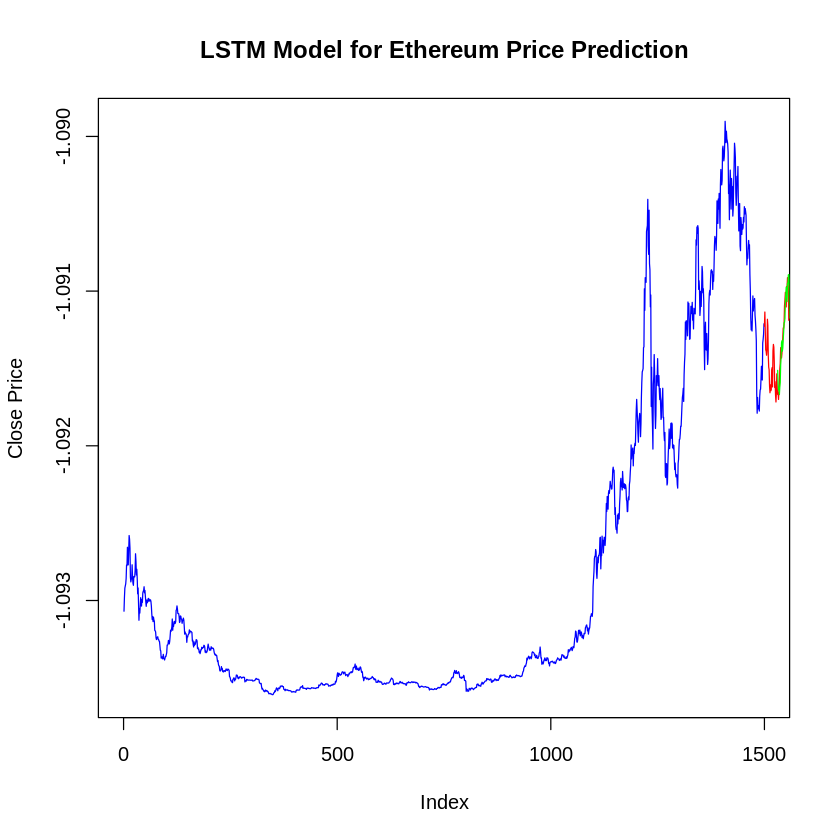

In [28]:
# 15. Plot the results
train_data_index <- seq(1, train_size, by = 1)
scaled_train_data <- scale(df1[1:train_size], center = attr(df1, "scaled:center"), scale = attr(df1, "scaled:scale"))
scaled_test_data <- scale(test_data, center = attr(df1, "scaled:center"), scale = attr(df1, "scaled:scale"))
scaled_y_pred <- scale(y_pred, center = attr(df1, "scaled:center"), scale = attr(df1, "scaled:scale"))
scaled_val_data <- scale(val_data, center = attr(df1, "scaled:center"), scale = attr(df1, "scaled:scale"))
scaled_y_pred_val <- scale(y_pred_val, center = attr(df1, "scaled:center"), scale = attr(df1, "scaled:scale"))

plot(train_data_index, scaled_train_data, type = 'l', col = 'blue', xlab = 'Index', ylab = 'Close Price',
     main = 'LSTM Model for Ethereum Price Prediction')
lines(seq(train_size + 1, train_size + test_size, by = 1), scaled_test_data, type = 'l', col = 'red')
lines(seq(train_size + 32, train_size + test_size, by = 1), scaled_y_pred, type = 'l', col = 'green')
lines(seq(train_size + test_size + 1, length(df1), by = 1), scaled_val_data, type = 'l', col = 'purple')
lines(seq(train_size + test_size + 32, length(df1), by = 1), scaled_y_pred_val, type = 'l', col = 'orange')
